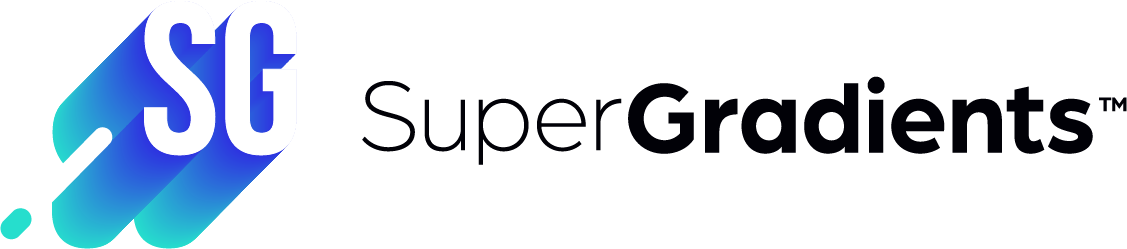

# SuperGradients How To Use a model to Predict

In this tutorial we will use SG pretrained models to predict on an image.

The notebook is divided into 3 tasks:
1. Semantic segmentation
2. Classification
3. Object detection


Notes:
Detection and Classification support a simplified API, where all you need to do is to call `model.predict(image)`, with image can be anything from numpy array, image url, a folder with images of video file. You can find more information [here](https://docs.deci.ai/super-gradients/documentation/source/ModelPredictions.html)

In [ ]:
!pip install -qq super-gradients==3.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to buil


# 1. Object detection

For the sake of this presentation, We'll use COCO dataset that can be found [here](https://cocodataset.org/#home).

We will use YoloX-S model for inference.



[2023-10-30 14:41:02] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolox_s
[2023-10-30 14:41:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


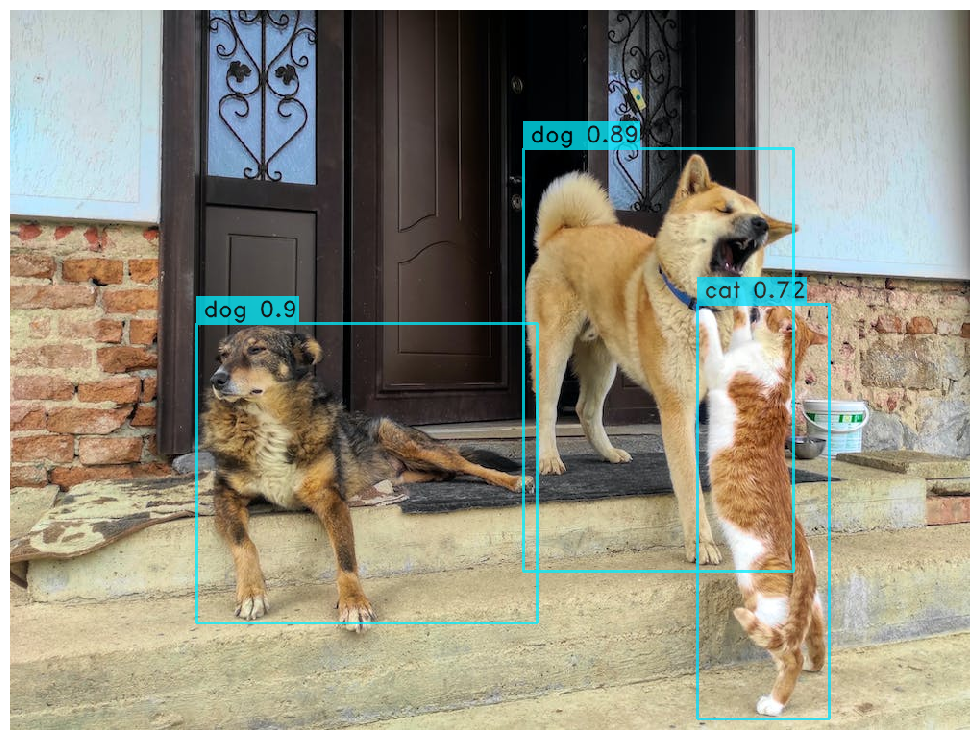

In [ ]:
from super_gradients.training import models


model = models.get("yolox_s", pretrained_weights="coco")

predictions = model.predict("https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/images/examples/dogs_and_cat.jpeg?raw=true", conf=0.70) # You can play with the `conf` and `iou` parameters
predictions.show()

# 2. Classification


For the sake of this presentation, We'll use ImageNet dataset that can be found [here](https://www.image-net.org/).

We will use ResNet-18 model for inference.

[2023-10-30 14:24:41] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture resnet50
[2023-10-30 14:24:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


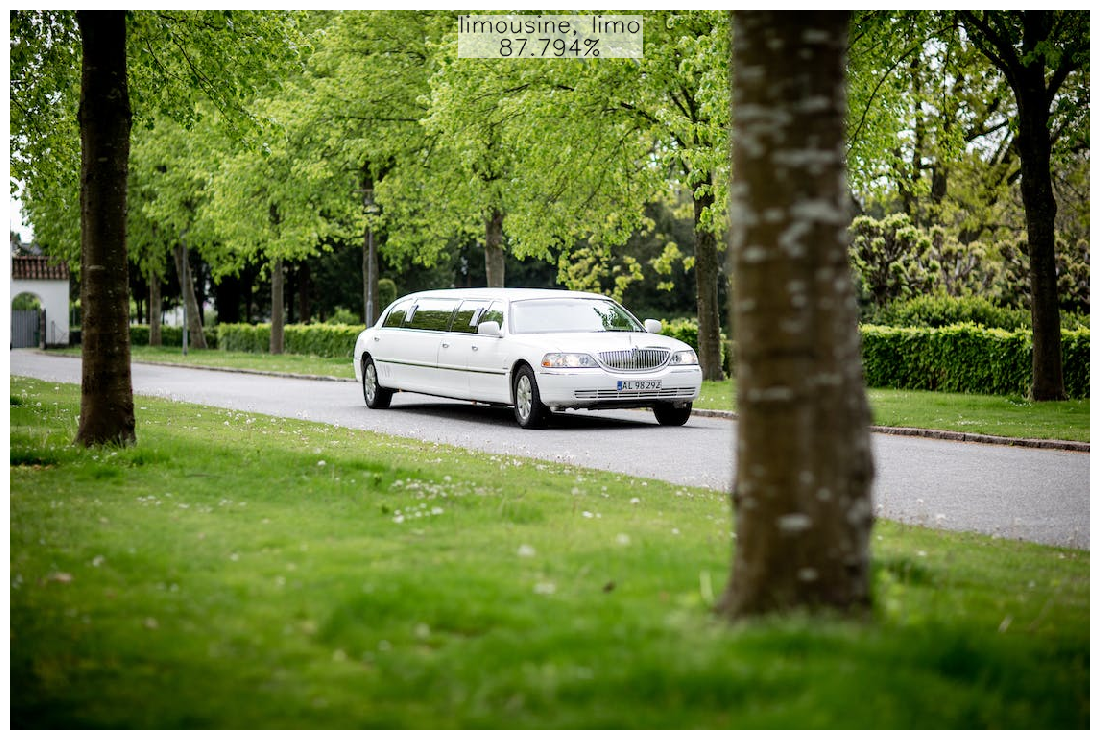

In [ ]:
model = models.get("resnet50", pretrained_weights="imagenet")

prediction = model.predict("https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/images/examples/car.jpeg?raw=true")
prediction.show()

# 3. Semantic segmentation


Currently, the segmentation task does not support the `model.predict` API.

Therefore, we will need to include preprocessing steps, as well as visualization scripts.

For the sake of this presentation, We'll use Supervise.ly dataset that can be found [here](https://docs.supervise.ly/).

We will use PP-Lite-T model for inference.


### A. Load an image

In [ ]:
import requests
from PIL import Image
from io import BytesIO

# Image can be both uploaded to colab server or by a direct URL
url =  "https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/images/examples/man_profile_picture.jpeg?raw=true"

# Load image from url
response = requests.get(url)

# Get PIL image
image = Image.open(BytesIO(response.content))

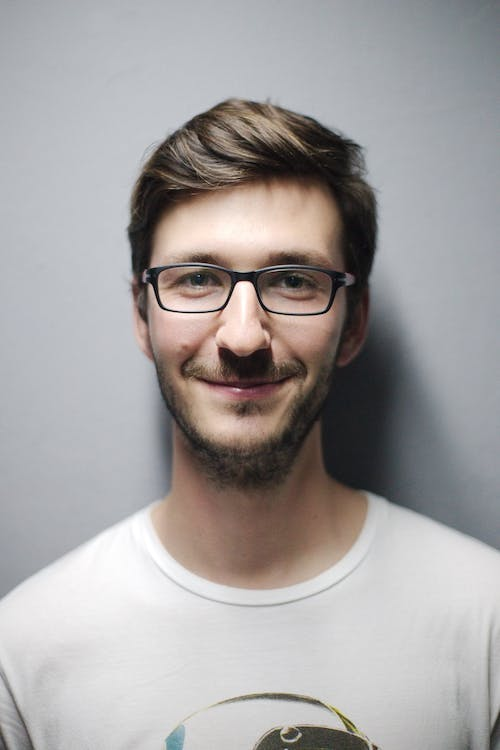

(500, 750)


In [ ]:
# Visualize
print(image.size)
image

### Preprocess

In [ ]:
import torchvision.transforms as transforms
import torch

# Prepare preprcoess transformations
pre_proccess = transforms.Compose([
    transforms.Resize([640, 640]),
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])

# Run preprocess on image. unsqueeze for [Batch x Channels x Width x Height] format
transformed_image = pre_proccess(image).unsqueeze(0)

### B. Load a pretrained model


In [ ]:
# We will use weights that have been created with pp-lite-seg model on the supervise.ly dataset.
# Get pre-trained weights
! wget "https://deci-pretrained-models.s3.amazonaws.com/ppliteseg/supervisely/pplite_t/ckpt_best.pth"

--2023-10-30 14:25:04--  https://deci-pretrained-models.s3.amazonaws.com/ppliteseg/supervisely/pplite_t/ckpt_best.pth
Resolving deci-pretrained-models.s3.amazonaws.com (deci-pretrained-models.s3.amazonaws.com)... 52.216.204.187, 52.217.113.145, 52.217.68.148, ...
Connecting to deci-pretrained-models.s3.amazonaws.com (deci-pretrained-models.s3.amazonaws.com)|52.216.204.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96694741 (92M) [binary/octet-stream]
Saving to: ‘ckpt_best.pth.2’

ckpt_best.pth.2      89%[================>   ]  82.09M  26.8MB/s    eta 0s     

In [ ]:
from super_gradients.training import models

# Get model from super-gradients repository.
model = models.get("pp_lite_t_seg50",
                   num_classes=1,
                   checkpoint_path='ckpt_best.pth')

ckpt_best.pth.2     100%[===================>]  92.21M  26.8MB/s    in 3.4s    

2023-10-30 14:25:08 (26.8 MB/s) - ‘ckpt_best.pth.2’ saved [96694741/96694741]



[2023-10-30 14:25:08] INFO - checkpoint_utils.py - Successfully loaded model weights from ckpt_best.pth EMA checkpoint.


### C. Inferenece

In [ ]:
# Predict using SG model
model = model.eval()
mask = model(transformed_image)

### Postprocess

In [ ]:
# Run post-proccess - apply sigmoid to output probabilities, then apply hard
# threshold of 0.5 for binary mask prediction.
mask = torch.sigmoid(mask).gt(0.5).squeeze()
mask = transforms.ToPILImage()(mask.float())

Text(0.5, 1.0, 'Original')

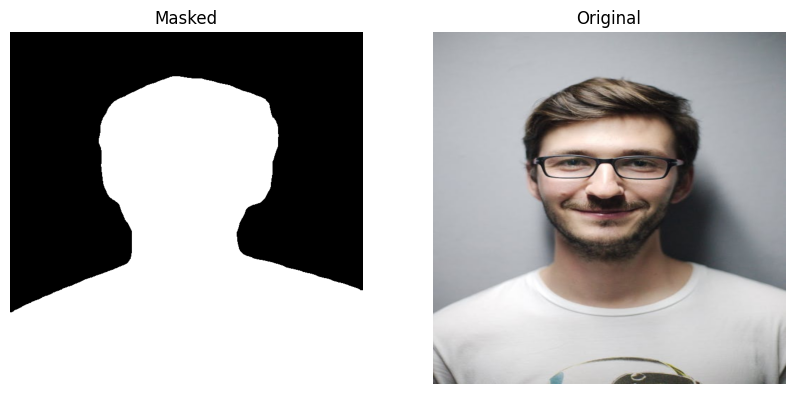

In [ ]:
# Visualize
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title("Masked")
fig.add_subplot(1, 2, 2)
plt.imshow(transforms.Resize([640, 640])(image))
plt.axis('off')
plt.title("Original")